# Table Lenght Measurements

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)
- Christian Michelsen (Niels Bohr Institute)


### Date:    
- 22-11-2018 (latest update)

***

Python program for analysing measurements of the length of the lecture table in Auditorium A at NBI.  
There are two measurements each with estimated error of the table length:
1. Measurement with a 30cm ruler.
2. Measurement with a 2m folding ruler.
 
Each person was asked not only to state the measurement, but also their estimated uncertainty. None of the persons could see others measurements in order to get the largest degree of independence. Also, the 30cm ruler measurement was asked to be done first.

***

In [1]:
# First, import the modules you want to use:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
from probfit import BinnedLH, Chi2Regression, Extended, UnbinnedLH # Helper tool for fitting
import sys
from scipy import stats
from scipy.special import erfc


And add out our custom functions:

In [2]:
sys.path.append('../../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

Options for the program: 

In [3]:
blinded = True
apply_chauvenets_criterion = True
save_plots = False

r = np.random          # Random numbers
r.seed(42)             # We set the numbers to be random, but the same for each run

## Functions:

Function to find the bin centers and counts in a range from `xmin` to `xmax` of a histogram `hist`:

In [4]:
def get_bincenter_and_counts_in_range(hist, xmin=None, xmax=None):
    
    if xmin is None:
        xmin = np.min(hist)
    if xmax is None:
        xmax = np.max(hist)
    
    counts, bin_edges, _ = hist
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    mask1 = (xmin < bin_centers) & (bin_centers <= xmax) 
    mask2 = counts > 0
    mask_final = mask1 & mask2
    return bin_centers[mask_final], counts[mask_final], np.sqrt(counts[mask_final])

Function to calculate the $\chi^2$-value:

In [5]:
def calculate_chi2(function, x_values, y_values, sy_values, *fitparameters):
    # traditional loop-version
    chi2_val = 0
    entries = 0
    for x, y, sy in zip(x_values, y_values, sy_values):
        if y > 0:
            f = function(x, *fitparameters) # calc the model value
            residual  = ( y-f ) / sy  # find the uncertainty-weighted residual
            chi2_val += residual**2  # the chi2-value is the squared residual
            entries += 1 # count the bin as non-empty since sy>0 (and thus y>0)
    
    # numpy version
    mask = (y_values>0)
    yhat = function(x_values, *fitparameters)
    chi2_val = np.sum( (y_values[mask]-yhat[mask])**2/sy_values[mask]**2)
    entries = sum(mask)
            
    return chi2_val, entries

A Gaussian PDF (unit integral):

In [6]:
# Define your PDF / model 
def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)

Extended Gaussian PDF (including normalisation, which enables fit to histograms):

In [7]:
def gauss_extended(x, N, mu, sigma) :
    """Non-normalized Gaussian"""
    return N * gauss_pdf(x, mu, sigma)

## Initial data analysis:

Before we even look at the look at the data, we decide whether or not we want to blind the analysis by adding a constat to all measurements:


In [8]:
if blinded:
    blinding = r.normal(0, 0.1)      # I add a constant (Gaussian with +-10cm) to remain "blind"
else:
    blinding = 0

Define what datafiles we want to look at. Extend it to suit your analysis: 

In [9]:
infiles = ["data_TableMeasurements2018.txt",
           "data_TableMeasurements2017.txt",
           "data_TableMeasurements2016.txt",
           "data_TableMeasurements2015.txt",
           "data_TableMeasurements2014.txt",
           "data_TableMeasurements2013.txt",
           "data_TableMeasurements2012.txt",
           "data_TableMeasurements2011.txt",
           "data_TableMeasurements2010.txt",
           "data_TableMeasurements2009.txt"]

We read in all the data from the `infiles` files:

In [10]:
L30cm = np.array([])
eL30cm = np.array([])
L2m = np.array([])
eL2m = np.array([])

# Loop over files and open them
for infile in infiles:
    
    tmp_L30cm, tmp_eL30cm, tmp_L2m, tmp_eL2m = np.loadtxt(infile, skiprows=2, unpack=True)
    
    L30cm = np.append(L30cm, tmp_L30cm + blinding)
    eL30cm = np.append(eL30cm, tmp_eL30cm)
    L2m = np.append(L2m, tmp_L2m + blinding)
    eL2m = np.append(eL2m, tmp_eL2m)
    
N_read  = len(L30cm)       # Number of measurements read in total


print(f"\n\nRead all {len(infiles)} file(s) which included {N_read} measurements. \n")



Read all 10 file(s) which included 495 measurements. 



Now we plot the data:

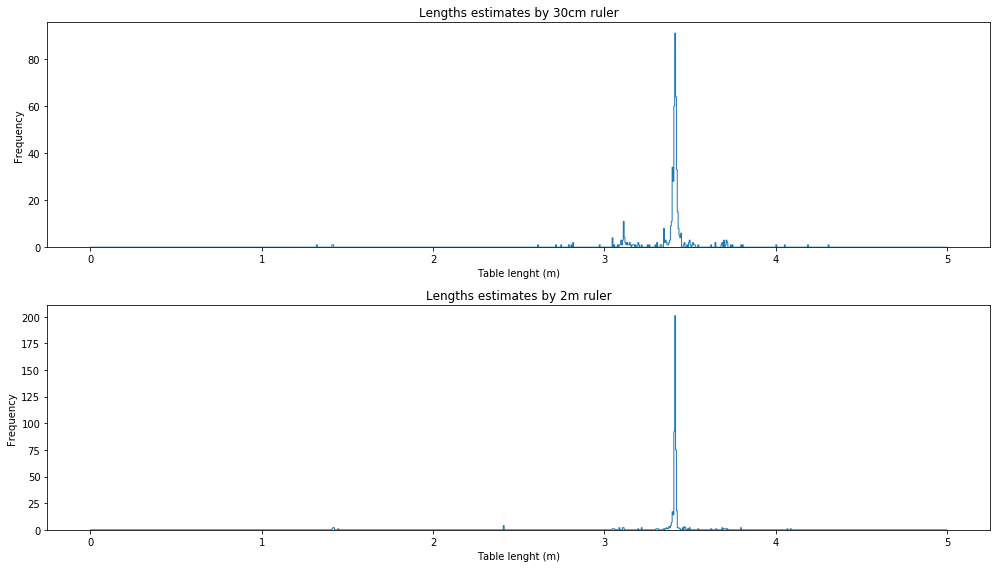

In [11]:
minL = 0.0
maxL = 5.0

## Define two histograms with all the lengths recorded:
fig_raw, ax = plt.subplots(nrows=2, figsize=(14,8))
ax_L30cm, ax_L2m = ax

hist_L30cm = ax_L30cm.hist(L30cm, bins=1000, range=(minL, maxL), histtype='step', label='Binned Data')
ax_L30cm.set(xlabel='Table lenght (m)', ylabel='Frequency', title='Lengths estimates by 30cm ruler')

hist_L2m = ax_L2m.hist(L2m, bins=1000, range=(minL, maxL), histtype='step', label='Binned Data')
ax_L2m.set(xlabel='Table lenght (m)', ylabel='Frequency', title='Lengths estimates by 2m ruler')

fig_raw.tight_layout()

## 30 cm ruler:

We consider the measurements for the 30cm ruler and focus on that for now. Below is a mean and RMS calculation along with a general Gaussian fit to all the data. Somehow, it doesn't seem optimal/right...

In [12]:
print(f"  Initial estimate (30 cm ruler):  {L30cm.mean():.3f} +- {L30cm.std(ddof=1)/np.sqrt(len(L30cm)):.3f} m")

  Initial estimate (30 cm ruler):  3.379 +- 0.010 m


We set up the fit. Can you guess why we use the binwidth `L30cm_binwidth` in the inital value for `N`in the fit?

In [13]:
print("\n\nL30cm raw fit: \n")

L30cm_x, L30cm_y, L30cm_sy = get_bincenter_and_counts_in_range(hist_L30cm, 3.0, 3.7)
L30cm_binwidth = L30cm_x[1] - L30cm_x[0]

chi2_L30cm = Chi2Regression(gauss_extended, L30cm_x, L30cm_y, L30cm_sy) 
minuit_L30cm = Minuit(chi2_L30cm, pedantic=False, N=L30cm_y.sum()*L30cm_binwidth, mu=L30cm.mean(), sigma=L30cm.std(ddof=1)) 
minuit_L30cm.migrad();

# the fitted values of the parameters
L30cm_fit_N, L30cm_fit_mu, L30cm_fit_sigma = minuit_L30cm.args 



L30cm raw fit: 



FCN = 357.1519475223496 
 TOTAL NCALL = 135 
 NCALLS = 135 
 
 
 EDM = 4.174794303695252e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,N,1.40925,0.339632,,,,,No
1,mu,3.40276,0.0518009,,,,,No
2,sigma,0.270153,0.0857666,,,,,No


Now we plot the fit on the figure and extract relevant extra information:

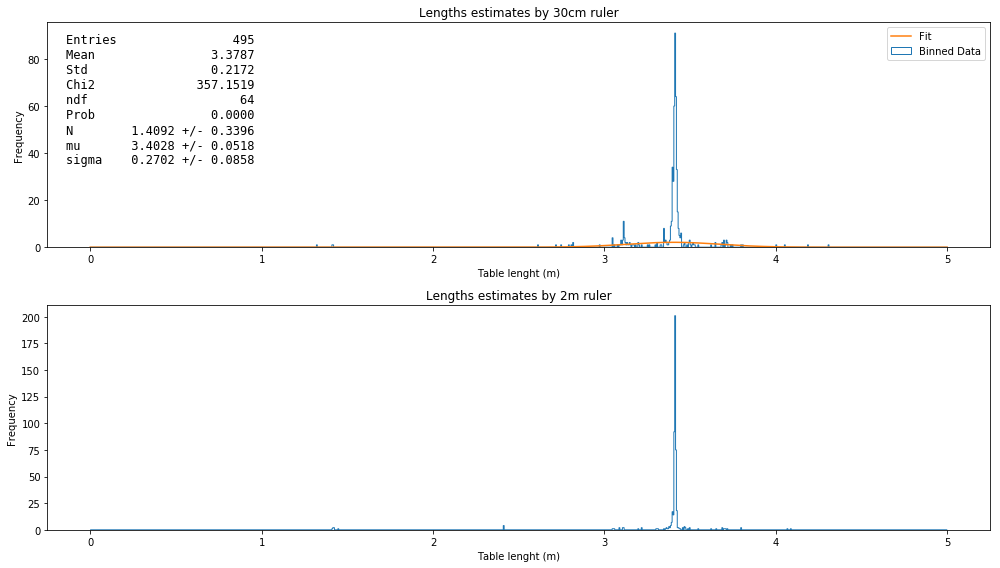

In [14]:
# Create the x-axis for the plot of the fitted function
xaxis = np.linspace(minL, maxL, 10000) 

# Compute the fitted function for x_fit
yaxis = gauss_extended(xaxis, *minuit_L30cm.args) 

# Plot the fitted function
ax_L30cm.plot(xaxis, yaxis, '-', label='Fit')

# Compute the chi2, the number of non-empty bins, the NDOF and the chi2-probability
L30cm_chi2, L30cm_entries = calculate_chi2(gauss_extended, L30cm_x, L30cm_y, L30cm_sy, *minuit_L30cm.args)
L30cm_NDOF = L30cm_entries - len(minuit_L30cm.args)
L30cm_chi2_prob =  stats.chi2.sf(L30cm_chi2, L30cm_NDOF) 


# make the results ready to be plotted
d = {'Entries': len(L30cm), 
     'Mean': L30cm.mean(), 
     'Std': L30cm.std(ddof=1), 
     'Chi2': L30cm_chi2, 
     'ndf': L30cm_NDOF, 
     'Prob': L30cm_chi2_prob, 
    }
for name in minuit_L30cm.parameters:
    d[name] = [minuit_L30cm.values[name], minuit_L30cm.errors[name]]

# add these results to the plot 
text = nice_string_output(d, extra_spacing=2, decimals=4)
add_text_to_ax(0.02, 0.95, text, ax_L30cm, fontsize=12)

ax_L30cm.legend()

# show the actual fit and fit results
fig_raw

***

Start by taking a close look at the data, first by inspecting the numbers in the data file (yes, open the damn thing, and look over the numbers by eye!), and then by
considering the histograms produced by running the notebook. 

To begin with, only consider the 30cm ruler measurements, and disregard the estimated/guessed uncertainties. You can then expand from there, as guided below by questions.

# Questions:

1. Consider the mean and width. Is the result as you would expect it? And do you think that it is close to the best possible (i.e. most accurate and precise) estimate? NOTE: Make sure that you know the difference between accuracy and precision!!! See "Common definition" in: http://en.wikipedia.org/wiki/Accuracy_and_precision

2. Do any of the measurements looks wrong/bad/suspecious? Do you see any repeated mistakes done for obvious reasons? Would you correct or exclude any of the measurements and how would you justify this? This problem requires that you discuss internally, and then each do what you think most justified/best. Apply this to the list of measurements, and perhaps produce a new list with your accepted measurements in (to save the original data). How many measurements did you throw away in the end?

3. Fit your accepted length measurements with a Gaussian distribution, possibly in a (small?) range around what you believe is the true value. Should the binning be changed for these fits? And is the Gaussian distribution justified? Also, do you see any "human" effects? Did any of your class mates (or you?) not read to mm precision?

4. Once you have selected the measurements you want to use, calculate the mean, RMS and uncertainty on the mean. How much did your result improve in precision?


#### Now repeat the above for the 2m folding rule
 
***


5. How much better/worse is the single measurement uncertainty from the 30cm ruler case to the 2m folding rule?

6. The "Pull" distribution is defined as the plot of $z_i = \left(x_i - \mu \right)/\sigma_i$ where $\mu$ is the *sample* mean of $x$, and $x_i$ and $\sigma_i$ are the single measurements and their corresponding uncertainties. If the measurements and uncertainties are good, then it should give a unit Gaussian. Is that the case? And thus, were the uncertainty estimates/guesses reasonable? If not, then the pull standard deviation is often used to remove overly precise measurements, and scale the errors on the remaining measurements to a reasonable level.

7. Try to calculate the weighted mean. Did you get a good Chi2 probability, when doing so? Do you need to discard more dubious measurements? Did the result improve further in precision?

8. Does the length of the table seems to be different when measured with a 30cm and a 2m ruler? Quantify this statement! I.e. what is the difference, and what is the uncertainty on that difference? Is this significantly away from 0?

9. If you were asked for the best estimate of the length of the table, what would you do? (If posssible, read Bevington page 58 bottom!)


### Not too advanced questions:
10. Consider the 2018 data file with additional information in (Gender and measurement speed), and find out if gender and measurement speed have an impact on the quality of the measurements.

### Advanced questions:
11. Is there any correlation between the errors on the measurements and the distance value? I.e. do you see any effect of those measuring e.g. too long having a smaller/larger uncertainty? What would the effect of this be?